In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import yfinance as yf
import quantstats as qs
qs.extend_pandas()

In [3]:
equity_etfs = ['VTI','BND']
stock_frames = []
stock_daily_frames = []

for tick in equity_etfs:
    data = yf.download(tick, start="1980-01-01", group_by='ticker', interval='1d')
    data = data[['Adj Close']]
    data = data.rename(columns={'Adj Close': tick})
    stock_daily_frames.append(data)

equity_daily_returns = pd.concat(stock_daily_frames, axis=1)
equity_daily_returns = equity_daily_returns.pct_change().dropna()
equity_daily_returns = equity_daily_returns.dropna()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
def calculate_60_40_strategy(daily_returns, fees=0.01, name='60/40 Strategy'):
    # Ensure the indices are datetime objects
    daily_returns.index = pd.to_datetime(daily_returns.index)

    # Initialize the strategy returns column
    daily_returns[name] = np.nan

    # Define the allocation weights
    weights = {'VTI': 0.6, 'BND': 0.4}

    # Variable to track the first month's operation to avoid fees
    first_month = True

    # Iterate over each month
    for month_end in daily_returns.resample('M').last().index:
        # Apply the weights to the daily returns for the next month
        start_of_next_month = month_end + pd.DateOffset(days=1)
        end_of_next_month = start_of_next_month + pd.DateOffset(months=1) - pd.DateOffset(days=1)
        mask = (daily_returns.index >= start_of_next_month) & (daily_returns.index <= end_of_next_month)

        # Apply fees for rebalancing except for the first month
        if not first_month:
            daily_returns.loc[mask, name] = (daily_returns.loc[mask, ['VTI', 'BND']].dot(pd.Series(weights))) * (1 - fees)
        else:
            daily_returns.loc[mask, name] = daily_returns.loc[mask, ['VTI', 'BND']].dot(pd.Series(weights))
            first_month = False

    # Forward fill the NaN values
    daily_returns[name].fillna(method='ffill', inplace=True)

    return daily_returns

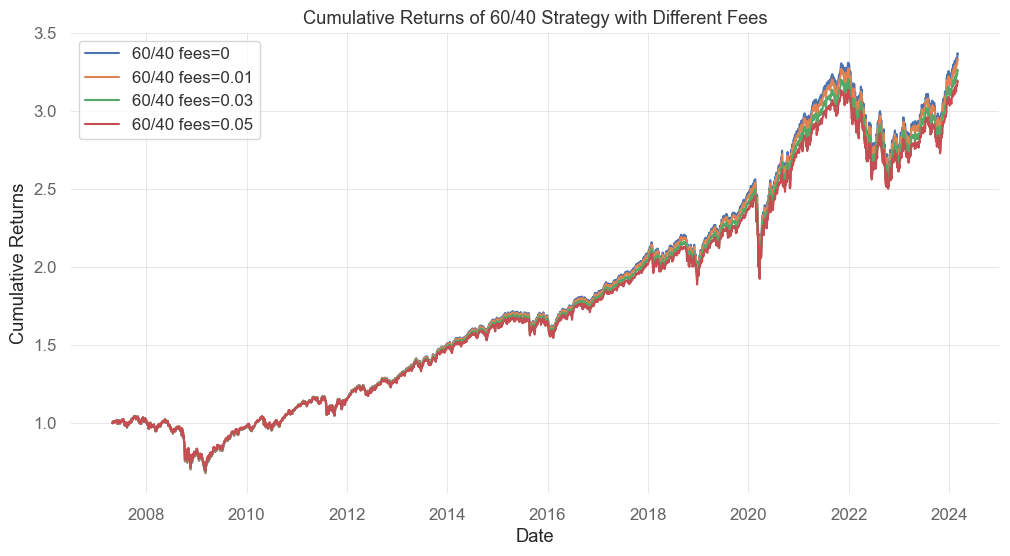

In [5]:
fee_levels = [0, 0.01, 0.03, 0.05]
import matplotlib.pyplot as plt 
# Compute the strategies
for fee in fee_levels:
    strategy_name = f"60/40 fees={fee}"
    calculate_60_40_strategy(equity_daily_returns, fees=fee, name=strategy_name)

# Calculate cumulative returns
cumulative_returns = (1 + equity_daily_returns.filter(like="60/40")).cumprod()

# Plotting
plt.figure(figsize=(12, 6))
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

plt.title("Cumulative Returns of 60/40 Strategy with Different Fees")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()

In [6]:
# qs.reports.html(equity_daily_returns['60/40 fees=0.01'], equity_daily_returns['VTI'], output="60_40 Strategy.html")